# A Simple LSTM-Based Time-Series Classifier (PyTorch)

The Recurrent Neural Network (RNN) architecutres show impressive results in tasks related to time-series processing and prediction. In this kernel, we're going to build a very simple LSTM-based classifier as an example of how one can apply RNN to classify a time-series data.

In [29]:
%matplotlib inline

In [30]:
from multiprocessing import cpu_count
from pathlib import Path

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

In [7]:
seed = 1
np.random.seed(seed)
torch.cuda.set_device(0)  # if you have more than one CUDA device

RuntimeError: No CUDA GPUs are available

## Loading The Data

First of all, we read the files and drop the irrelavant columns.

In [5]:
ROOT = Path.cwd().parent/'input'
SAMPLE = 'sample_submission.csv'
TRAIN = 'X_train.csv'
TARGET = 'y_train.csv'
TEST = 'X_test.csv'

ID_COLS = ['series_id', 'measurement_number']

x_cols = {
    'series_id': np.uint32,
    'measurement_number': np.uint32,
    'orientation_X': np.float32,
    'orientation_Y': np.float32,
    'orientation_Z': np.float32,
    'orientation_W': np.float32,
    'angular_velocity_X': np.float32,
    'angular_velocity_Y': np.float32,
    'angular_velocity_Z': np.float32,
    'linear_acceleration_X': np.float32,
    'linear_acceleration_Y': np.float32,
    'linear_acceleration_Z': np.float32
}

y_cols = {
    'series_id': np.uint32,
    'group_id': np.uint32,
    'surface': str
}

In [32]:
x_trn = pd.read_csv(TRAIN, usecols=x_cols.keys(), dtype=x_cols)
x_tst = pd.read_csv(TEST, usecols=x_cols.keys(), dtype=x_cols)
y_trn = pd.read_csv(TARGET, usecols=y_cols.keys(), dtype=y_cols)

## PyTorch Wrappers

Before we can start training a `torch` model, we need to convert `pandas` data frames into PyTorch-specific data types. The main classes here are `Dataset` and `DataLoader`. The functions below split the dataset into training and validation subsets, and wrap them with data loaders.

In [38]:
def create_datasets(X, y, test_size=0.2, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size=0.1)
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    print(X_train.shape)
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc


def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [37]:
create_grouped_array(x_trn).shape

(3810, 128, 10)

## Cyclic Learning Rate

The recent papers by L. Smith show us that the cyclic learning rate schedulers have very positive influence on model's convergence speed. In the following cells, we implement a simple cosine scheduler for our model.

In [13]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [14]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

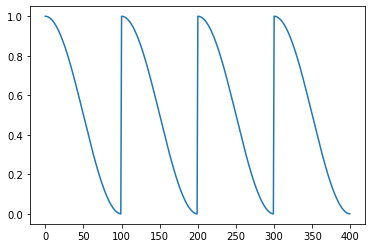

In [15]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

## The LSTM Model

Our classifier contains of several LSTM cells (hidden under the hood of `nn.LSTM`),  and one `nn.Linear` layer. Note that we use `batch_first=True` to make sure that the first dimension of our tensors is interpreted as a batch size, and the next one - as a time dimension.

In [16]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [39]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['surface'])

Preparing datasets
torch.Size([3429, 128, 10])


In [18]:
bs = 128
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=cpu_count())

Creating data loaders with batch size: 128


In [19]:
for i, (x_batch, y_batch) in enumerate(trn_dl):
    print(x_batch.shape)
    print(y_batch.shape)
    break
    

torch.Size([128, 128, 10])
torch.Size([128])


## Training Loop

Finally, we are ready to bring everything together and train the model.

In [ ]:
input_dim = 10    
hidden_dim = 256
layer_dim = 3
output_dim = 9
seq_dim = 128

lr = 0.0005
n_epochs = 1000
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

In [15]:
print('The training is finished! Restoring the best model weights')

The training is finished! Restoring the best model weights


## Submission

Next, we load the best weights and run model on the testing dataset.

In [16]:
model.load_state_dict(torch.load('best.pth'))

In [17]:
model.eval()

LSTMClassifier(
  (rnn): LSTM(10, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [18]:
test_dl = DataLoader(create_test_dataset(x_tst), batch_size=64, shuffle=False)

In [19]:
test = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    out = model(batch.cuda())
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()

Predicting on test dataset


In [20]:
submit = pd.read_csv(SAMPLE)
submit['surface'] = enc.inverse_transform(test)
submit.to_csv('submit.csv', index=None)